# 1.Contexto de negócio

In [2]:
from IPython.display import Image

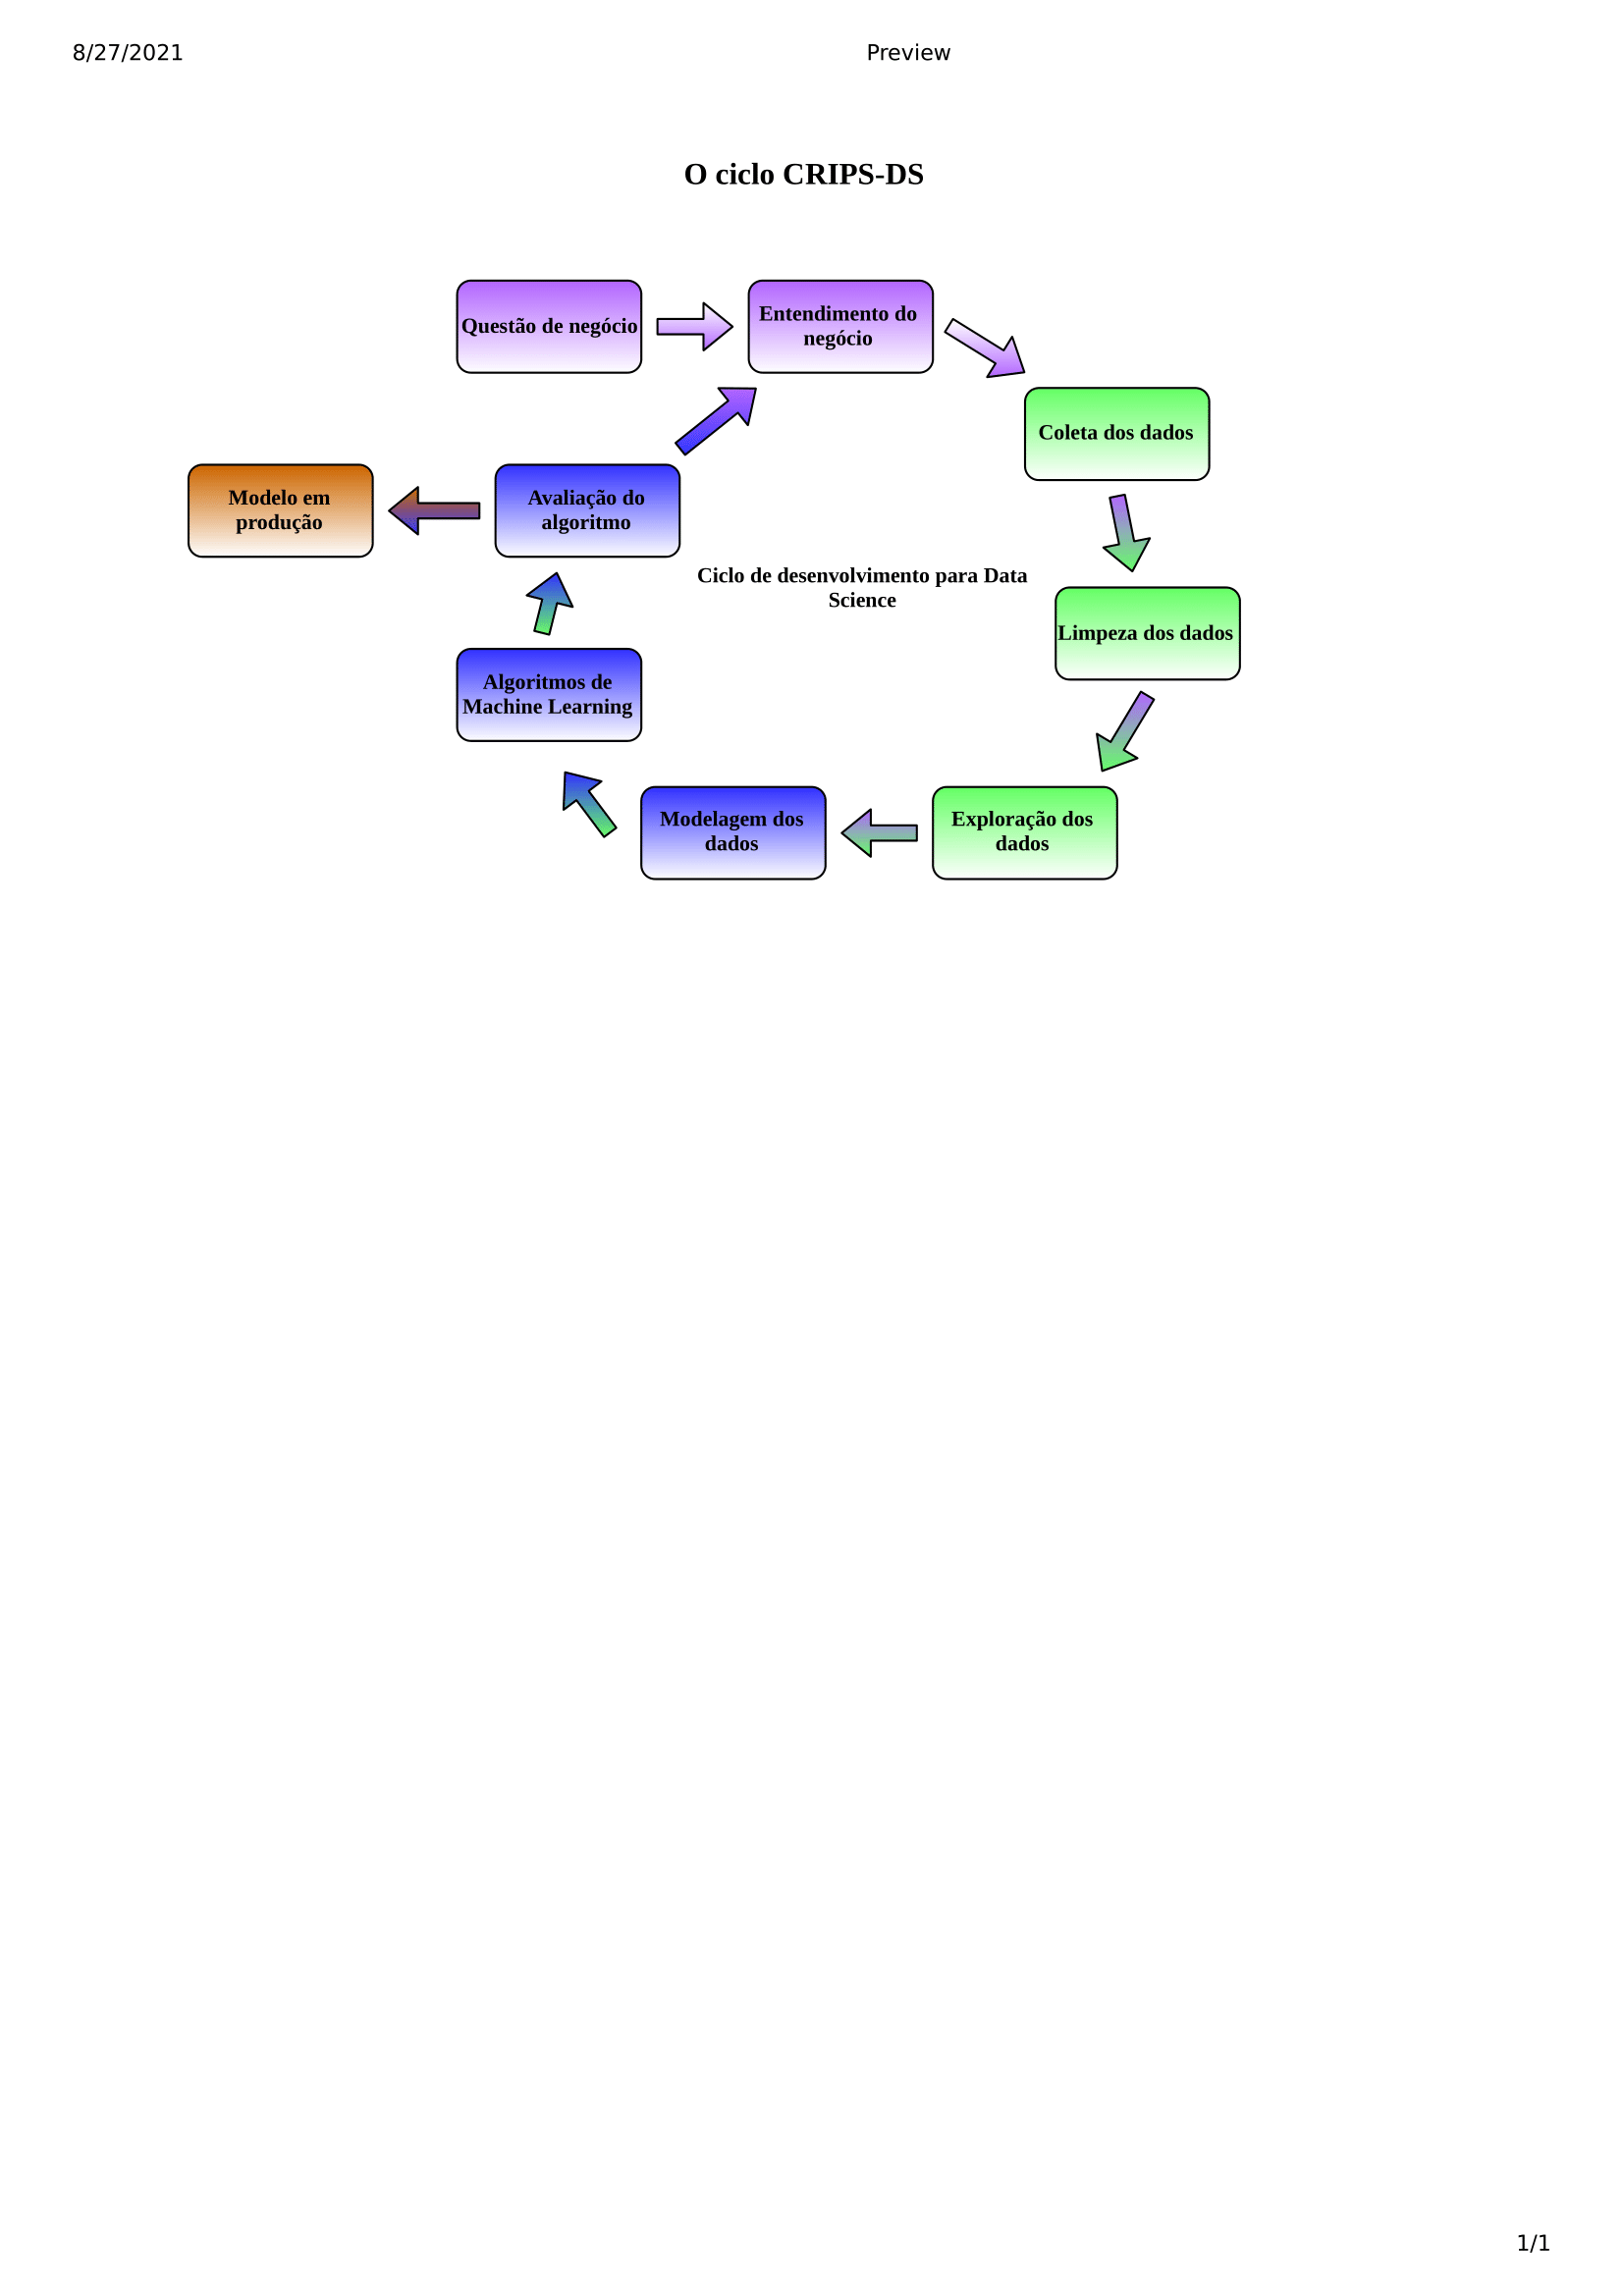

In [3]:
Image('img/CRIPS-DS-RE.jpg')

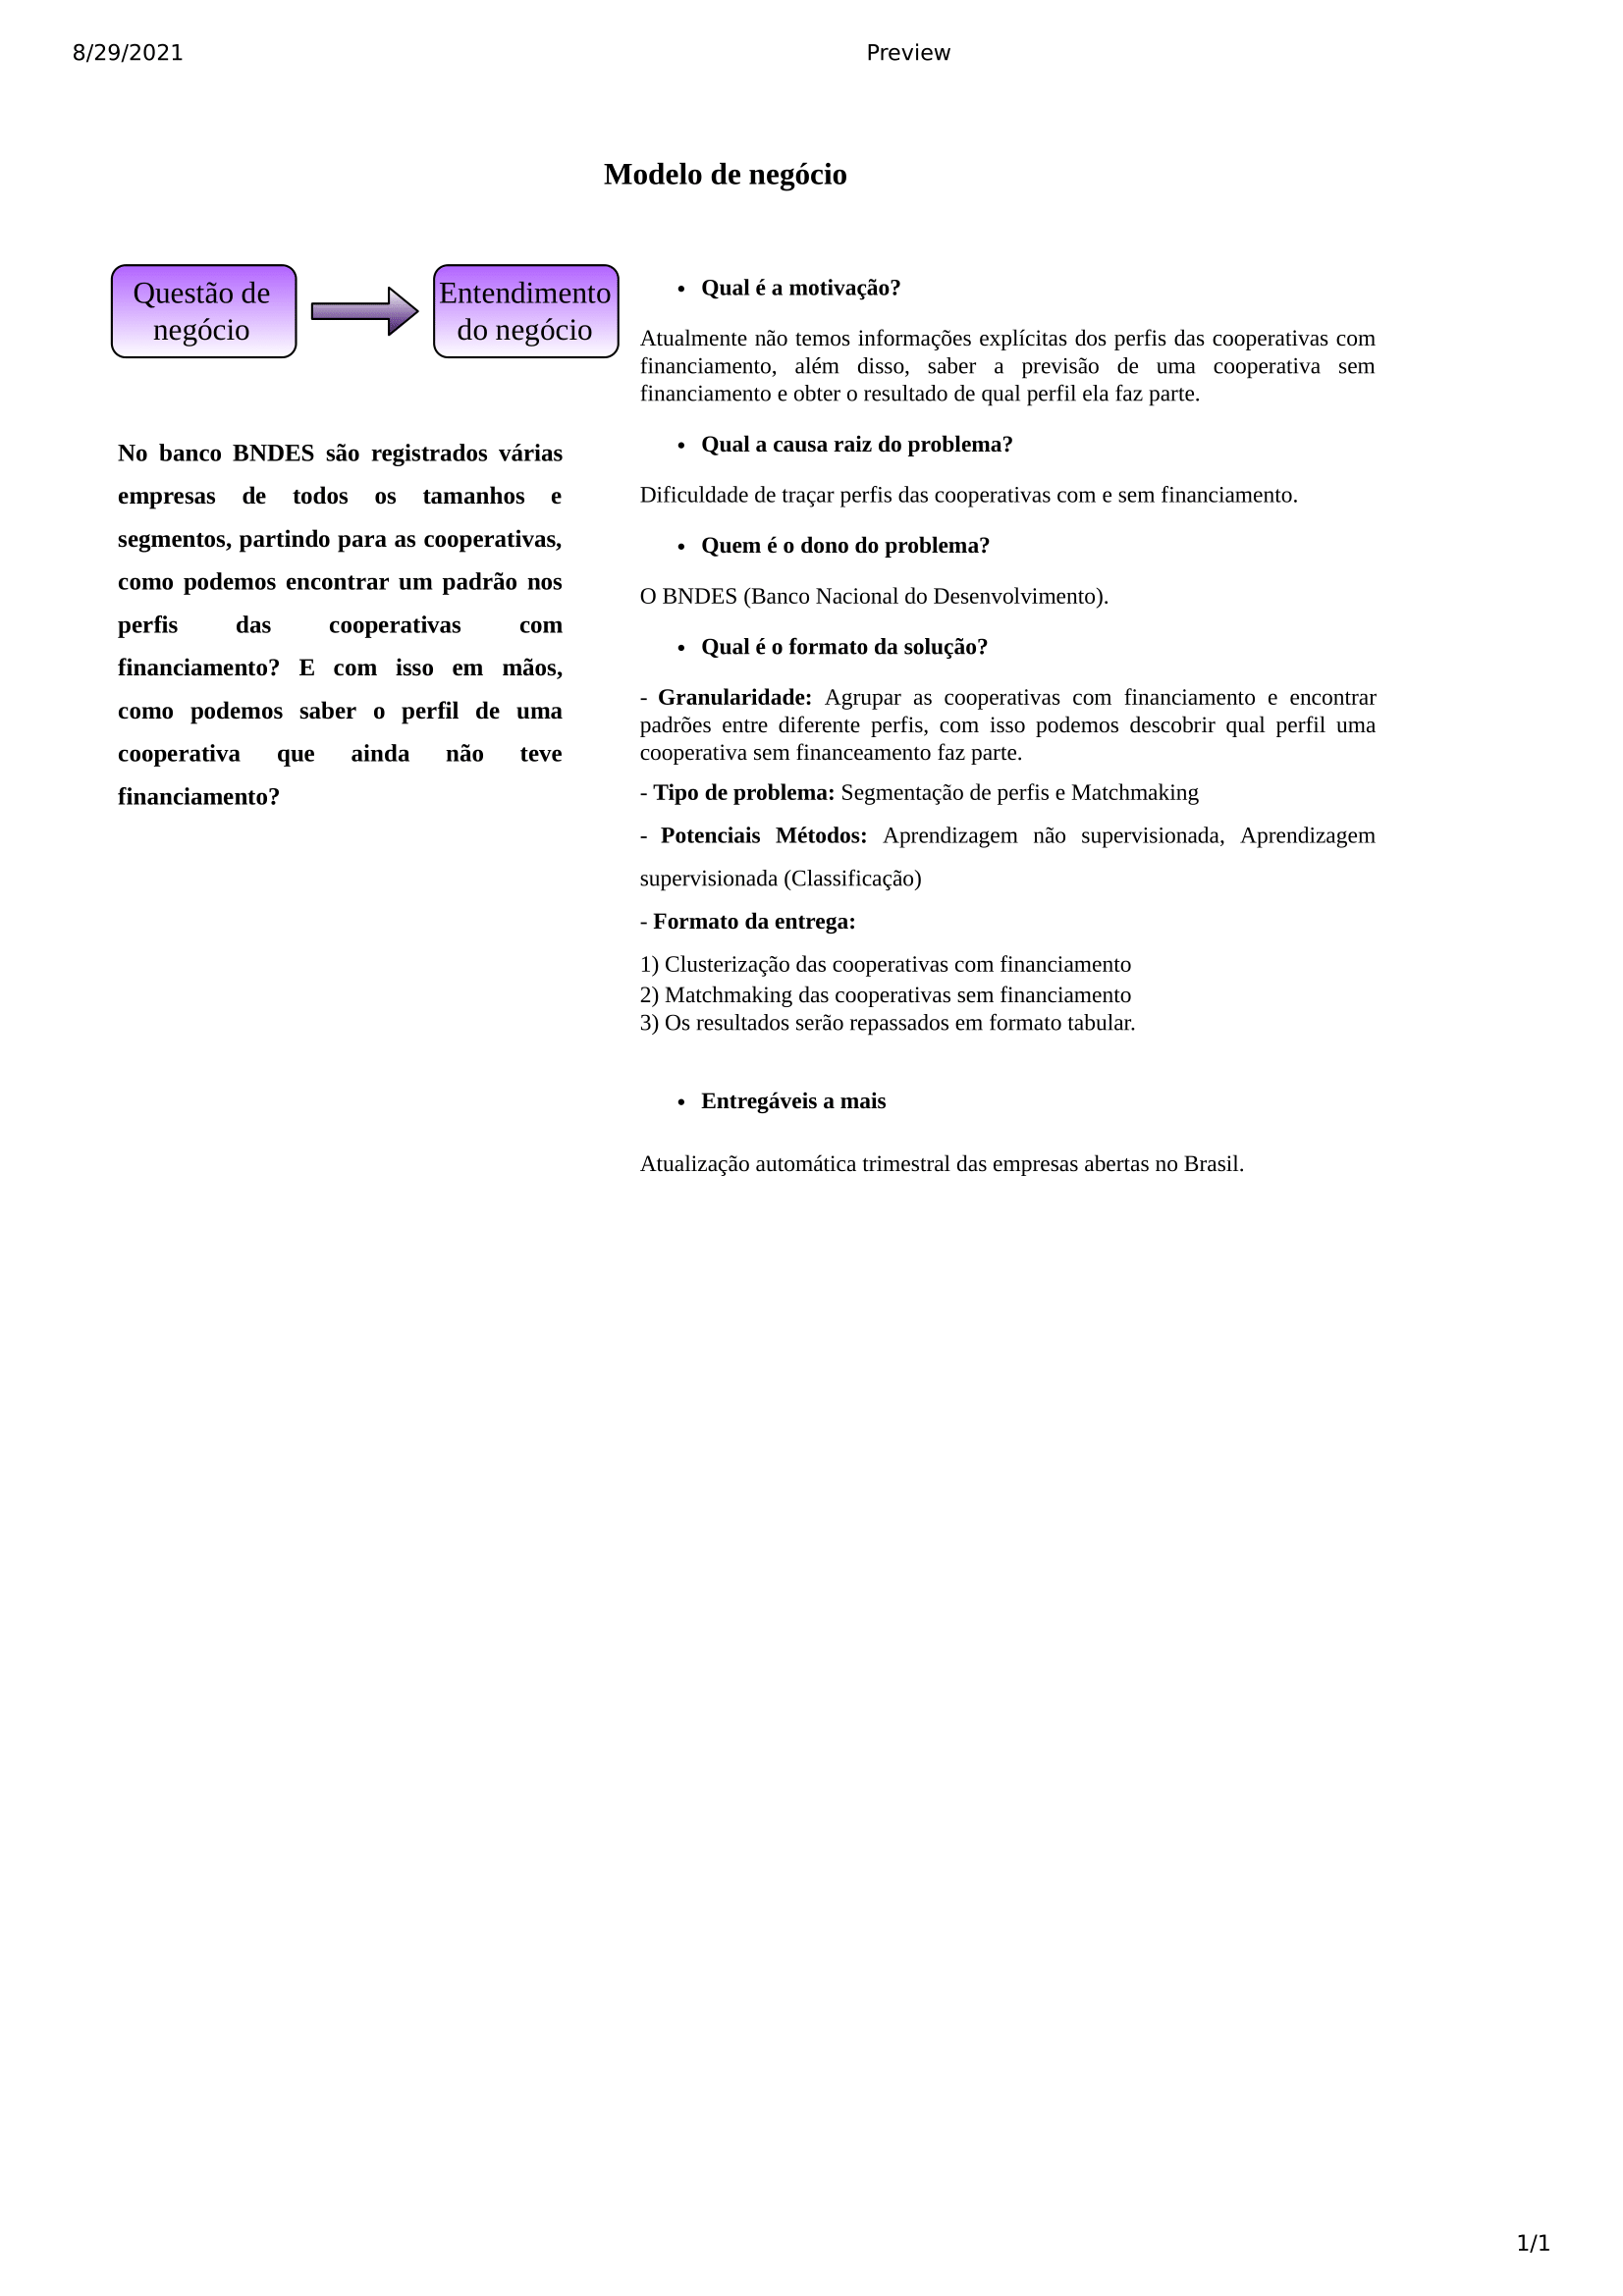

In [4]:
Image('img/modelo-negocio-RE.jpg')

# 2.Extração dos dados

## 2.1. Bibliotecas

In [199]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning algorithms
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Model validation, pre-processing and metrics
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler#, OrdinalEncoder
from sklearn.metrics import classification_report, precision_score, recall_score

from category_encoders.ordinal import OrdinalEncoder

# Pre-processing pipelines for models
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

## 2.2. Configurações adicionais

In [42]:
%matplotlib inline
sns.set_style(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.display.max_columns = None

In [245]:
BASE_DIR = os.path.join(os.path.abspath('.'))
MODELS_DIR = os.path.join(BASE_DIR, 'models')
ARCHIVE_DIR = os.path.join(BASE_DIR, 'archive')

## 2.3. Extraçao

In [8]:
data = pd.read_excel(os.path.join(ARCHIVE_DIR, 'cross-table-join.xlsx'))

In [17]:
cols_coops_ativas = [
    'id',
    'cnpj_base',
    'cnpj_ordem',
    'cnpj_dv',
    'situacao_data',
    'atividade_inicio',
    'cnae_principal',
    'cep',
    'uf',
    'municipio',
    'cnae_descricao',
    'natureza',
    'capital_social',
    'porte_empresa',
    'natureza_descricao',
    'label'
]

In [18]:
df = data.loc[:, cols_coops_ativas].copy()

# 3. Limpeza dos dados

In [20]:
df1 = df.copy()

## 3.1 Descrição dos dados

In [22]:
df1.shape

(16542, 16)

In [21]:
exploration = pd.DataFrame({
    'column': df1.columns, 'type': df1.dtypes, 'NA #': df1.isna().sum(), 'NA %': round((df1.isna().sum() / df1.shape[0]) * 100, 2)
})
exploration.sort_values('NA %', ascending=False)

,column,type,NA #,NA %
atividade_inicio,atividade_inicio,datetime64[ns],64,0.39
id,id,object,0,0.00
cnpj_base,cnpj_base,int64,0,0.00
cnpj_ordem,cnpj_ordem,int64,0,0.00
cnpj_dv,cnpj_dv,int64,0,0.00
situacao_data,situacao_data,datetime64[ns],0,0.00
cnae_principal,cnae_principal,int64,0,0.00
cep,cep,int64,0,0.00
uf,uf,object,0,0.00
municipio,municipio,object,0,0.00


## 3.2. Separação dos dados por tipo

In [28]:
num_features = df1.select_dtypes(include=np.number).columns.tolist()
cat_features = df1.select_dtypes(include=np.object).columns.tolist()

In [33]:
df1[num_features]

,cnpj_base,cnpj_ordem,cnpj_dv,cnae_principal,cep,natureza,capital_social,label
0,71238232,1,20,6424703,35534000,2143,0.0,2
1,71238232,1,20,6424703,35534000,2143,0.0,2
2,71238232,1,20,6424703,35534000,2143,0.0,2
3,71238232,1,20,6424703,35534000,2143,0.0,2
4,71238232,1,20,6424703,35534000,2143,0.0,2
...,...,...,...,...,...,...,...,...
16537,38643136,1,92,4623108,38690000,2143,0.0,2
16538,38643136,1,92,4623108,38690000,2143,0.0,2
16539,17033358,1,13,4789099,38970000,2143,32000.0,2
16540,94890266,1,9,161099,96170000,2143,0.0,2


In [44]:
df1[cat_features]

,id,uf,municipio,cnae_descricao,porte_empresa,natureza_descricao
0,382320001MG,MG,CAMPOS ALTOS,Cooperativas de crédito mútuo,demais,Cooperativa
1,382320001MG,MG,CAPITAO ANDRADE,Cooperativas de crédito mútuo,demais,Cooperativa
2,382320001MG,MG,PRESIDENTE OLEGARIO,Cooperativas de crédito mútuo,demais,Cooperativa
3,382320001MG,MG,TEOFILO OTONI,Cooperativas de crédito mútuo,demais,Cooperativa
4,382320001MG,MG,TEOFILO OTONI,Cooperativas de crédito mútuo,demais,Cooperativa
...,...,...,...,...,...,...
16537,431360001MG,MG,FORMOSO,Comércio atacadista de matérias-primas agrícol...,demais,Cooperativa
16538,431360001MG,MG,FORMOSO,Comércio atacadista de matérias-primas agrícol...,demais,Cooperativa
16539,333580001MG,MG,CAMPOS ALTOS,Comércio varejista de outros produtos não espe...,demais,Cooperativa
16540,902660001RS,RS,SAO LOURENCO DO SUL,Atividades de apoio à agricultura não especifi...,demais,Cooperativa


# 4. Análise exploratório

In [49]:
df2 = df.copy()

## 4.1. Verificar balanceamento da variável dependente

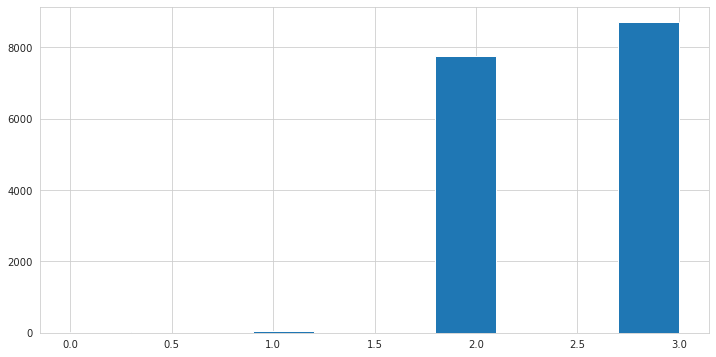

In [51]:
plt.hist(df2['label'])
plt.show()

In [103]:
df.label.value_counts(normalize=True) * 100

3    52.635715
2    46.904848
1     0.320397
0     0.139040
Name: label, dtype: float64

**Os cluster 3 e 4 são os que possuem maior concentração dos dados. Os clusters 1 e 2 estão altamente desbalanceados, somando a proporção dos dois não chega a 1% da base.**

## 4.2. Correlação entre as variáveis independentes vs variável dependente

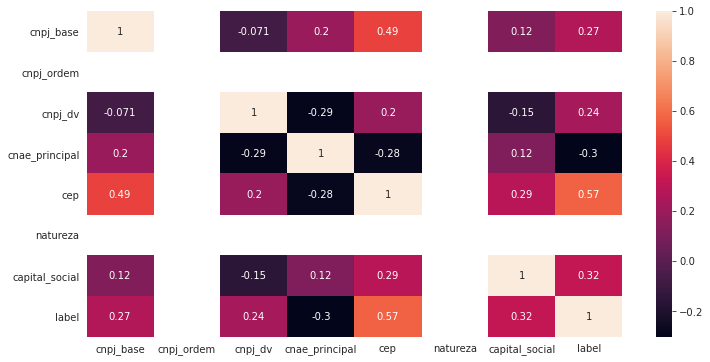

In [77]:
sns.heatmap(df2[num_features].corr(), annot=True)
plt.show()

**Variáveis independetes com maior poder de correlação com a variável dependente**

In [ ]:
#['cnpj_base', 'cnpj_dv', 'cep', 'capital_social']

## 4.3. Análise das variáveis quantitativas

In [89]:
pd.options.display.float_format = '${:,.2f}'.format
df.groupby('label').agg({'capital_social': ['mean', 'median', 'std']})

capital_social                          
                mean    median             std
label                                         
0         $79,925.44     $0.00     $299,821.59
1         $67,108.71 $1,050.00     $406,451.32
2      $1,556,257.37     $0.00   $7,211,647.85
3     $61,137,079.46     $0.00 $119,023,051.04

**O cluster 4 possue maior capital social, avaliando ao todo aproximadamente 61 Milhões**

In [90]:
pd.options.display.float_format = None

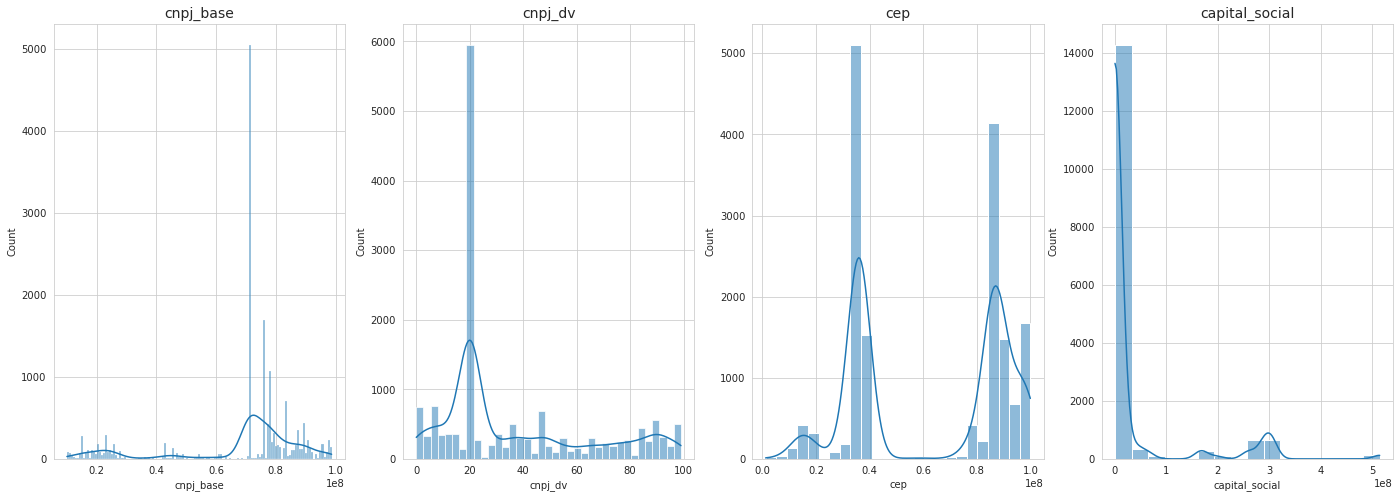

In [101]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24,8))


# cnpj_base
sns.histplot(df2['cnpj_base'], kde=True, ax=ax1)
ax1.set_title("cnpj_base", fontsize=14)

# cnpj_dv
sns.histplot(df2['cnpj_dv'], kde=True, ax=ax2)
ax2.set_title("cnpj_dv", fontsize=14)


# cep
sns.histplot(df2['cep'], kde=True, ax=ax3)
ax3.set_title("cep", fontsize=14)

# capital_social
sns.histplot(df2['capital_social'], kde=True, ax=ax4)
ax4.set_title("capital_social", fontsize=14)

plt.show()

**As distribuições das variáveis no plot seguem assimétricas, podendo, provavelmente, serem tratadas para os algoritmos de machine learning**

## 4.4 Análise das variáveis qualitativas

In [109]:
df2.groupby('label').agg({'uf': 'value_counts'}).T

label  0                              1                            2       \
uf    MG RS BA ES GO PR RJ MT SC SP  MG  RS  SC GO PR ES MS MT    MG   RS   
uf     4  4  3  3  2  2  2  1  1  1  17  16  11  3  3  1  1  1  5794  521   

label                                                                        \
uf      SC   PR   SP   MT   ES  RJ  RO  GO  BA  DF  PE AL PA MS PB CE RN AC   
uf     318  316  312  214  103  49  32  19  18  17  11  9  7  6  5  3  2  1   

label           3                                              
uf    AP SE    PR    RS    SC   MG   SP  MT  MS  RJ  GO ES AL  
uf     1  1  4010  1838  1149  889  613  84  67  31  21  4  1

Insights:
1. O Estado de Minas Gerais está mais concentrado nos clusters 1, 2 e 3.
2. No mesmo contexto, segue o Estado do Rio Grande do Sul posicionando em segundo lugar.
3. No cluster 3 o Estado do Paraná tem maior concentração.
4. O cluster 3 é o que maior representa em quantidade de dados da base

# 5. Modelagem dos dados

In [229]:
df3 = df.copy()

In [344]:
features_selected = ['cnpj_dv', 'cep', 'capital_social', 'uf']

## 5.1 Modelo baseline

In [119]:
encoder = OrdinalEncoder(cols=['uf'])
encoded = encoder.fit_transform(df3[features_selected], df3['label'])

/home/igobarros/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [193]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### RandomForest

In [138]:
rf = RandomForestClassifier()
rf_cv = cross_validate(rf, encoded, df3['label'], cv=skf)
print('Treino: {}\nTeste: {}'.format( rf_cv["fit_time"].mean(), rf_cv["test_score"].mean() ))

Treino: 0.46924571990966796
Teste: 0.9964937514228718


### ExtraTreesClassifier

In [140]:
etrees = ExtraTreesClassifier()
etrees_cv = cross_validate(etrees, encoded, df3['label'], cv=skf)
print('Treino: {}\nTeste: {}'.format( etrees_cv["fit_time"].mean(), etrees_cv["test_score"].mean() ))

Treino: 0.36700711250305174
Teste: 0.996433273659504


### AdaBoostClassifier

In [141]:
ada = AdaBoostClassifier()
ada_cv = cross_validate(ada, encoded, df3['label'], cv=skf)
print('Treino: {}\nTeste: {}'.format( ada_cv["fit_time"].mean(), ada_cv["test_score"].mean() ))

Treino: 0.24278979301452636
Teste: 0.8150136138916875


### GradientBoostingClassifier 

In [145]:
gboost = GradientBoostingClassifier()
gboost_cv = cross_validate(gboost, encoded, df3['label'], cv=skf)
print('Treino: {}\nTeste: {}'.format( gboost_cv["fit_time"].mean(), gboost_cv["test_score"].mean() ))

Treino: 2.815997076034546
Teste: 0.9690482663711112


### XGBClassifier

In [158]:
xgb = XGBClassifier(random_state=100)
xgb_cv = cross_validate(xgb, encoded, df3['label'], cv=skf)
print('Treino: {}\nTeste: {}'.format( xgb_cv["fit_time"].mean(), xgb_cv["test_score"].mean() ))

/home/igobarros/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/igobarros/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/igobarros/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/igobarros/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/igobarros/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/igobarros/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/igobarros/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/igobarros/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/igobarros/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Treino: 0.9433021068572998
Teste: 0.9963123364039959


/home/igobarros/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


### LogisticRegression

In [144]:
lr = LogisticRegression()
lr_cv = cross_validate(lr, encoded, df3['label'], cv=skf)
print('Treino: {}\nTeste: {}'.format( lr_cv["fit_time"].mean(), lr_cv["test_score"].mean() ))

Treino: 0.3181779861450195
Teste: 0.8035907895472499


## 5.2. Pipeline

In [345]:
X_train, X_test, y_train, y_test = train_test_split( df3[features_selected], df3['label'], random_state=1996)

In [346]:
# Pipeline de transformação dos dados

num_feature_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(fill_value='median')),
    ('scaler', StandardScaler()),
])

ordinal_feature_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num_features', num_feature_transformer, features_selected[:-1]),
    ('cat_feature', ordinal_feature_transformer, ['uf'])
])

In [347]:
def apply_pipeline(estimator, X, y,):
    '''
    Function responsible for applying the entire pepile of transformations to the data
    
    ----------
    parameters:
        estimator: Classifier
        type: sklearn object
        
        X: features
        type: matrix or pandas.DataFrame
        
        y: target
        type: array 1-D or pandas.Series
        
        return object pipeline
    '''
    
    #over = SMOTE(sampling_strategy=0.1, k_neighbors=3)
    #under = RandomUnderSampler(sampling_strategy=0.5)

    #pipe_resampling = Pipeline(steps=[('o', over), ('u', under), ('clf', estimator)])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', estimator)
    ])
    
    pipeline.fit(X, y)
    
    return pipeline

## 5.3. Hiperparametrização

In [194]:
def turning_model(estimator, X, y, params, **kwargs):
    '''
    Function responsible for performing the parameter search
    
    ----------
    parameters:
        estimator: classifier
        type: sklearn object
        
        X: features
        type: matrix or pandas.DataFrame
        
        y: target
        type: array 1-D or pandas.Series
        
        params: search parameters
        type: dict
        
        return object RandomizedSearchCV
        
    '''
    # Performs hyperparameter search
    random_cv = RandomizedSearchCV(estimator, param_distributions=params, cv=skf, **kwargs)
    random_cv.fit(X=X, y=y)
    
    return random_cv

In [348]:
xgb_pipeline = apply_pipeline(XGBClassifier(objective='multi:softprob'), X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:39:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [221]:
xgb_params = {
        'clf__max_depth': [10, None],
        'clf__min_samples_leaf': [1, 4],
        'clf__min_samples_split': [2, 5],
        'clf__n_estimators': [200, 400]
}

xgb_cv = turning_model(xgb_pipeline, X_train, y_train, params=xgb_params, n_jobs=-1, return_train_score=True) # executa o turning do modelo

/home/igobarros/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:31:14] WARNING: ../src/learner.cc:573: 
Parameters: { "min_samples_leaf", "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:31:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# 6. Validação do modelo

In [222]:
xgb_cv.best_params_, xgb_cv.best_score_

({'clf__n_estimators': 200,
  'clf__min_samples_split': 5,
  'clf__min_samples_leaf': 1,
  'clf__max_depth': None},
 0.9950024050633323)

In [349]:
y_pred = xgb_pipeline.predict(X_test)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [350]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.20      0.31        10
           1       0.73      0.67      0.70        12
           2       1.00      1.00      1.00      1924
           3       1.00      1.00      1.00      2190

    accuracy                           0.99      4136
   macro avg       0.85      0.72      0.75      4136
weighted avg       0.99      0.99      0.99      4136



In [355]:
from yellowbrick.classifier import ROCAUC
%matplotlib widget
visualizer = ROCAUC(xgb_pipeline, classes=[0, 1, 2, 3])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:title={'center':'ROC Curves for XGBClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [359]:
en = OrdinalEncoder(cols=['uf'])
X_tr = en.fit_transform(X_train, y_train)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [361]:
from yellowbrick.model_selection import FeatureImportances

%matplotlib widget
model = XGBClassifier(objective='multi:softprob')
viz = FeatureImportances(model)
viz.fit(X_tr, y_train)
viz.show()

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:42:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:title={'center':'Feature Importances of 4 Features using XGBClassifier'}, xlabel='relative importance'>

In [362]:
# Cria uma serie do pandas com as features usadas no modelo e o objeto da pesquisa por parâmetro
model_data = pd.Series({
    'features': features_selected,
    'model': xgb_pipeline 
})

# Salvo tudo no formato pkl
model_data.to_pickle( os.path.join( MODELS_DIR, 'xgb-model.pkl' ) )

# 7. Modelo em produção (Batch) - Escoramento

In [363]:
import pandas as pd

In [364]:
model_saved = pd.read_pickle( os.path.join( MODELS_DIR, 'xgb-model.pkl' ) ) # Ler o modelo salvo para ser usado

In [365]:
shoring_data = pd.read_parquet(os.path.join(ARCHIVE_DIR, 'cross-table-predict.parquet'))

In [366]:
copy_data = shoring_data[cols_coops_ativas[:-1]].copy()

In [367]:
shoring = shoring[model_saved['features']].copy()

In [377]:
idx_drop = shoring.loc[shoring['cep'] == ''].index
shoring.drop(index=idx_drop, inplace=True)
copy_data.drop(index=idx_drop, inplace=True)

In [379]:
prediction = model_saved['model'].predict(shoring)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [384]:
copy_data['matchmaking'] = prediction

In [389]:
copy_data.to_csv(os.path.join(ARCHIVE_DIR, 'shoring-matchmaking.csv'), index=False, sep=';')